In [ ]:
import kagglehub

path = kagglehub.dataset_download("jayasooryantm/table-extraction")
print("Path to dataset files:", path)

100%|██████████| 112M/112M [00:00<00:00, 179MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jayasooryantm/table-extraction/versions/2


In [ ]:
!apt-get install -y tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
!tesseract --version

tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [ ]:
!pip install opencv-python pytesseract scikit-learn

In [ ]:
import cv2
import pytesseract
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import os

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1024, 1024))
    _, img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_denoised = cv2.medianBlur(img_bin, 3)
    return img_denoised

def extract_text(image):
    return pytesseract.image_to_string(image)

def extract_text_features(text_corpus):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(text_corpus)
    return tfidf_matrix.toarray(), vectorizer.get_feature_names_out()

def reduce_features(features, n_components=100):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(features)

def process_documents(path):
    all_texts = []
    filenames = []

    for file in os.listdir(path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(path, file)
            preprocessed = preprocess_image(full_path)
            text = extract_text(preprocessed)
            all_texts.append(text)
            filenames.append(file)

    tfidf_features, feature_names = extract_text_features(all_texts)
    reduced_features = reduce_features(tfidf_features)

    return filenames, reduced_features, feature_names

if __name__ == "__main__":
    filenames, features, feature_names = process_documents(path)

    for i, fname in enumerate(filenames):
        print(f"{fname} → Feature vector (first 5 values): {features[i][:5]}")


10.1.1.160.559_28.jpg → Feature vector (first 5 values): [-0.07239711  0.12001841 -0.06126712  0.07398606 -0.04079155]
10.1.1.6.2215_30.jpg → Feature vector (first 5 values): [-0.02498951 -0.0511698  -0.0320153  -0.02212495  0.01372655]
10.1.1.1.2028_14.jpg → Feature vector (first 5 values): [-0.04378739 -0.0801937   0.04097035  0.02824452  0.12223294]
10.1.1.20.2130_25.jpg → Feature vector (first 5 values): [-0.20986099 -0.2216626   0.29312609  0.10695665 -0.04634133]
10.1.1.32.775_4.jpg → Feature vector (first 5 values): [ 0.19667838  0.10893289  0.03294432 -0.04101738 -0.07089349]
10.1.1.12.2649_5.jpg → Feature vector (first 5 values): [ 0.0187521   0.01193987 -0.04651721 -0.00217139 -0.00497572]
10.1.1.120.1619_13.jpg → Feature vector (first 5 values): [-0.00268635 -0.12922123  0.04389404  0.07567226  0.00759926]
10.1.1.175.3002_26.jpg → Feature vector (first 5 values): [ 0.15732369 -0.09594069 -0.16105789 -0.06043958 -0.07867322]
10.1.1.1.2806_2.jpg → Feature vector (first 5 value

In [ ]:
!apt-get install -y tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
import cv2
import pytesseract
import os
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1024, 1024))
    _, img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_denoised = cv2.medianBlur(img_bin, 3)
    return img_denoised

def divide_into_blocks(image, block_size):
    h, w = image.shape
    blocks = []

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if y + block_size <= h and x + block_size <= w:
                block = image[y:y+block_size, x:x+block_size]
                blocks.append(((x, y), block))
    return blocks

def extract_char_from_block(block_img):
    return pytesseract.image_to_string(block_img, config='--psm 10').strip()

def extract_from_dataset_blockwise(path, block_size=128):
    results = {}

    for file in os.listdir(path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(path, file)
            preprocessed = preprocess_image(full_path)
            blocks = divide_into_blocks(preprocessed, block_size)

            block_results = []
            for (x, y), block in blocks:
                char = extract_char_from_block(block)
                block_results.append({
                    "block_position": (x, y),
                    "char": char
                })

            results[file] = block_results

    return results
results = extract_from_dataset_blockwise(path, block_size=128)
print(results)

{'10.1.1.160.559_28.jpg': [{'block_position': (0, 0), 'char': ''}, {'block_position': (128, 0), 'char': 'ae'}, {'block_position': (256, 0), 'char': ''}, {'block_position': (384, 0), 'char': ''}, {'block_position': (512, 0), 'char': ''}, {'block_position': (640, 0), 'char': ''}, {'block_position': (768, 0), 'char': ''}, {'block_position': (896, 0), 'char': ''}, {'block_position': (0, 128), 'char': ''}, {'block_position': (128, 128), 'char': 'we'}, {'block_position': (256, 128), 'char': 'ss'}, {'block_position': (384, 128), 'char': '-_'}, {'block_position': (512, 128), 'char': 'ves'}, {'block_position': (640, 128), 'char': '_'}, {'block_position': (768, 128), 'char': 'wears'}, {'block_position': (896, 128), 'char': ''}, {'block_position': (0, 256), 'char': ''}, {'block_position': (128, 256), 'char': 'se'}, {'block_position': (256, 256), 'char': 'Se'}, {'block_position': (384, 256), 'char': '8'}, {'block_position': (512, 256), 'char': 'ao'}, {'block_position': (640, 256), 'char': 'ee'}, {

In [ ]:
!pip install pytesseract

In [ ]:
import cv2
import pytesseract
import os
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1024, 1024))
    _, img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_denoised = cv2.medianBlur(img_bin, 3)
    return img_denoised

def divide_into_blocks(image, block_size):
    h, w = image.shape
    blocks = []

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if y + block_size <= h and x + block_size <= w:
                block = image[y:y+block_size, x:x+block_size]
                blocks.append(((x, y), block))
    return blocks

def extract_char_from_block(block_img):
    return pytesseract.image_to_string(block_img, config='--psm 10').strip()

def extract_from_dataset_blockwise(path, block_size=128):
    results = {}

    for file in os.listdir(path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(path, file)
            preprocessed = preprocess_image(full_path)
            blocks = divide_into_blocks(preprocessed, block_size)

            block_results = []
            for (x, y), block in blocks:
                char = extract_char_from_block(block)
                block_results.append({
                    "block_position": (x, y),
                    "char": char
                })

            results[file] = block_results

    return results

In [ ]:
import cv2
import pytesseract
import os
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1024, 1024))
    _, img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_denoised = cv2.medianBlur(img_bin, 3)
    return img_denoised

def divide_into_blocks(image, block_size):
    h, w = image.shape
    blocks = []

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if y + block_size <= h and x + block_size <= w:
                block = image[y:y+block_size, x:x+block_size]
                blocks.append(((x, y), block))
    return blocks

def extract_char_from_block(block_img):
    return pytesseract.image_to_string(block_img, config='--psm 10').strip()

def extract_from_dataset_blockwise(path, block_size=128):
    results = {}

    for file in os.listdir(path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(path, file)
            preprocessed = preprocess_image(full_path)
            blocks = divide_into_blocks(preprocessed, block_size)

            block_results = []
            for (x, y), block in blocks:
                char = extract_char_from_block(block)
                block_results.append({
                    "block_position": (x, y),
                    "char": char
                })

            results[file] = block_results

    return results
results = extract_from_dataset_blockwise(path, block_size=128)

In [ ]:
import cv2
import pytesseract
import os
import numpy as np

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1024, 1024))
    _, img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_denoised = cv2.medianBlur(img_bin, 3)
    return img_denoised

def divide_into_blocks(image, block_size):
    h, w = image.shape
    blocks = []

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if y + block_size <= h and x + block_size <= w:
                block = image[y:y+block_size, x:x+block_size]
                blocks.append(((x, y), block))
    return blocks

def extract_char_from_block(block_img):
    return pytesseract.image_to_string(block_img, config='--psm 10').strip()

def extract_from_dataset_blockwise(path, block_size=128):
    results = {}

    for file in os.listdir(path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(path, file)
            preprocessed = preprocess_image(full_path)
            blocks = divide_into_blocks(preprocessed, block_size)

            block_results = []
            for (x, y), block in blocks:
                char = extract_char_from_block(block)
                block_results.append({
                    "block_position": (x, y),
                    "char": char
                })

            results[file] = block_results

    return results

In [ ]:
results = extract_from_dataset_blockwise(path, block_size=128)

for fname, blocks in results.items():
    print(f"\n🖼️ {fname} →")
    for block in blocks[:5]:
        print(f"  Block at {block['block_position']} → '{block['char']}'")



🖼️ 10.1.1.160.633_6.jpg →
  Block at (0, 0) → 'a'
  Block at (128, 0) → 'ce'
  Block at (256, 0) → 'oe'
  Block at (384, 0) → 'ire'
  Block at (512, 0) → '|'

🖼️ 10.1.1.120.1546_10.jpg →
  Block at (0, 0) → ''
  Block at (128, 0) → '.'
  Block at (256, 0) → 'Dimension'
  Block at (384, 0) → ''
  Block at (512, 0) → 'Feature Set'

🖼️ 10.1.1.1.2087_15.jpg →
  Block at (0, 0) → ''
  Block at (128, 0) → ''
  Block at (256, 0) → ''
  Block at (384, 0) → ''
  Block at (512, 0) → ''

🖼️ 10.1.1.160.699_17.jpg →
  Block at (0, 0) → ''
  Block at (128, 0) → 'r='
  Block at (256, 0) → 'a'
  Block at (384, 0) → 'ae'
  Block at (512, 0) → '—'

🖼️ 10.1.1.1.2134_223.jpg →
  Block at (0, 0) → ''
  Block at (128, 0) → ''
  Block at (256, 0) → ''
  Block at (384, 0) → 'a MA LOHING.'
  Block at (512, 0) → 'be rween wane'

🖼️ 10.1.1.6.2284_7.jpg →
  Block at (0, 0) → 'ie'
  Block at (128, 0) → 'a'
  Block at (256, 0) → 'tee ee'
  Block at (384, 0) → 'cao'
  Block at (512, 0) → 'ime'

🖼️ 10.1.1.6.2367_13.

In [ ]:
import cv2
import pytesseract
import os
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1024, 1024))
    _, img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_denoised = cv2.medianBlur(img_bin, 3)
    return img_denoised

def divide_into_blocks(image, block_size):
    h, w = image.shape
    blocks = []
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if y + block_size <= h and x + block_size <= w:
                block = image[y:y+block_size, x:x+block_size]
                blocks.append(((x, y), block))
    return blocks

def extract_char_from_block(block_img):
    return pytesseract.image_to_string(block_img, config='--psm 10').strip()

def compute_glcm_features(block_img):
    quantized = (block_img // 32).astype(np.uint8)

    glcm = graycomatrix(quantized, distances=[1], angles=[0], levels=8, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return {
        "contrast": contrast,
        "correlation": correlation,
        "energy": energy,
        "homogeneity": homogeneity
    }

def process_dataset_with_glcm(path, block_size=128):
    results = {}

    for file in os.listdir(path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(path, file)
            preprocessed = preprocess_image(full_path)
            blocks = divide_into_blocks(preprocessed, block_size)

            block_data = []
            for (x, y), block in blocks:
                char = extract_char_from_block(block)
                glcm_features = compute_glcm_features(block)

                block_data.append({
                    "block_position": (x, y),
                    "char": char,
                    "glcm": glcm_features
                })

            results[file] = block_data

    return results


In [ ]:
import cv2
import pytesseract
import cv2
import os
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1024, 1024))
    _, img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_denoised = cv2.medianBlur(img_bin, 3)
    return img_denoised

def divide_into_blocks(image, block_size):
    h, w = image.shape
    blocks = []
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if y + block_size <= h and x + block_size <= w:
                block = image[y:y+block_size, x:x+block_size]
                blocks.append(((x, y), block))
    return blocks

def extract_char_from_block(block_img):
    return pytesseract.image_to_string(block_img, config='--psm 10').strip()

def compute_glcm_features(block_img):
    quantized = (block_img // 32).astype(np.uint8)

    glcm = graycomatrix(quantized, distances=[1], angles=[0], levels=8, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return {
        "contrast": contrast,
        "correlation": correlation,
        "energy": energy,
        "homogeneity": homogeneity
    }

def process_dataset_with_glcm(path, block_size=128):
    results = {}

    for file in os.listdir(path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(path, file)
            preprocessed = preprocess_image(full_path)
            blocks = divide_into_blocks(preprocessed, block_size)

            block_data = []
            for (x, y), block in blocks:
                char = extract_char_from_block(block)
                glcm_features = compute_glcm_features(block)

                block_data.append({
                    "block_position": (x, y),
                    "char": char,
                    "glcm": glcm_features
                })

            results[file] = block_data

    return results

path = "."
results = process_dataset_with_glcm(path, block_size=128)


for fname, blocks in results.items():
    print(f"\n📄 {fname} →")
    for block in blocks[:3]:
        print(f"  Block {block['block_position']} → '{block['char']}' | GLCM: {block['glcm']}")
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1024, 1024))
    _, img_bin = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_denoised = cv2.medianBlur(img_bin, 3)
    return img_denoised

def divide_into_blocks(image, block_size):
    h, w = image.shape
    blocks = []
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if y + block_size <= h and x + block_size <= w:
                block = image[y:y+block_size, x:x+block_size]
                blocks.append(((x, y), block))
    return blocks

def extract_char_from_block(block_img):
    return pytesseract.image_to_string(block_img, config='--psm 10').strip()

def compute_glcm_features(block_img):
    quantized = (block_img // 32).astype(np.uint8)

    glcm = graycomatrix(quantized, distances=[1], angles=[0], levels=8, symmetric=True, normed=True)

    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return {
        "contrast": contrast,
        "correlation": correlation,
        "energy": energy,
        "homogeneity": homogeneity
    }

def process_dataset_with_glcm(path, block_size=128):
    results = {}

    for file in os.listdir(path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(path, file)
            preprocessed = preprocess_image(full_path)
            blocks = divide_into_blocks(preprocessed, block_size)

            block_data = []
            for (x, y), block in blocks:
                char = extract_char_from_block(block)
                glcm_features = compute_glcm_features(block)

                block_data.append({
                    "block_position": (x, y),
                    "char": char,
                    "glcm": glcm_features
                })

            results[file] = block_data

    return results

results = process_dataset_with_glcm(path, block_size=128)


for fname, blocks in results.items():
    print(f"\n📄 {fname} →")
    for block in blocks[:3]:
        print(f"  Block {block['block_position']} → '{block['char']}' | GLCM: {block['glcm']}")

In [ ]:
for fname, blocks in results.items():
    print(f"\n📄 {fname} →")
    for block in blocks[:3]:
        position = block['block_position']
        char = block['char']
        glcm = block['glcm']
        print(f"  Block {position} → '{char}' | GLCM: {glcm}")


In [ ]:
path = "."

results = process_dataset_with_glcm(path, block_size=128)

if not results:
    print("⚠️ No images processed. Check your folder path or image extensions.")
else:
    for fname, blocks in results.items():
        print(f"\n📄 {fname} →")
        for block in blocks[:3]:
            position = block['block_position']
            char = block['char']
            glcm = block['glcm']
            print(f"  Block {position} → '{char}' | GLCM: {glcm}")


⚠️ No images processed. Check your folder path or image extensions.


In [ ]:
!pip install scikit-image

In [ ]:
import numpy as np

def compute_gldh_features(block_img, max_gray_level=256):

    if len(block_img.shape) > 2:
        block_img = cv2.cvtColor(block_img, cv2.COLOR_BGR2GRAY)

    diff_list = []
    h, w = block_img.shape
    for y in range(h):
        for x in range(w - 1):
            diff = abs(int(block_img[y, x]) - int(block_img[y, x + 1]))
            diff_list.append(diff)

    diff_array = np.array(diff_list)
    gldh_hist, _ = np.histogram(diff_array, bins=np.arange(0, max_gray_level + 1))

    gldh_hist = gldh_hist / (np.sum(gldh_hist) + 1e-8)

    return gldh_hist


In [ ]:
def process_dataset_with_gldh(path, block_size=128):
    results = {}

    for file in os.listdir(path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            full_path = os.path.join(path, file)
            preprocessed = preprocess_image(full_path)
            blocks = divide_into_blocks(preprocessed, block_size)

            block_data = []
            for (x, y), block in blocks:
                char = extract_char_from_block(block)
                gldh = compute_gldh_features(block)

                block_data.append({
                    "block_position": (x, y),
                    "char": char,
                    "gldh": gldh.tolist()
                })

            results[file] = block_data

    return results


In [ ]:
results = process_dataset_with_gldh(path, block_size=128)

for fname, blocks in results.items():
    print(f"\n📄 {fname} →")
    for block in blocks[:2]:
        print(f"  Block {block['block_position']} → '{block['char']}'")
        print(f"  GLDH (first 10 bins): {block['gldh'][:10]}")


        Image Character Block Position  Contrast  Energy
0    img1.jpg         A         (0, 0)      3.94    0.19
1    img1.jpg         B       (128, 0)      1.43    0.17
2    img2.jpg         C         (0, 0)      1.95    0.18
3    img2.jpg         D       (128, 0)      3.30    0.14
4    img3.jpg         E         (0, 0)      2.72    0.15
5    img3.jpg         F       (128, 0)      1.50    0.11
6    img4.jpg         G         (0, 0)      2.63    0.19
7    img4.jpg         H       (128, 0)      1.52    0.13
8    img5.jpg         I         (0, 0)      2.81    0.13
9    img5.jpg         J       (128, 0)      1.25    0.14
10   img6.jpg         K         (0, 0)      1.79    0.15
11   img6.jpg         L       (128, 0)      1.41    0.13
12   img7.jpg         M         (0, 0)      2.78    0.11
13   img7.jpg         N       (128, 0)      3.43    0.19
14   img8.jpg         O         (0, 0)      3.58    0.15
15   img8.jpg         P       (128, 0)      2.51    0.17
16   img9.jpg         Q        

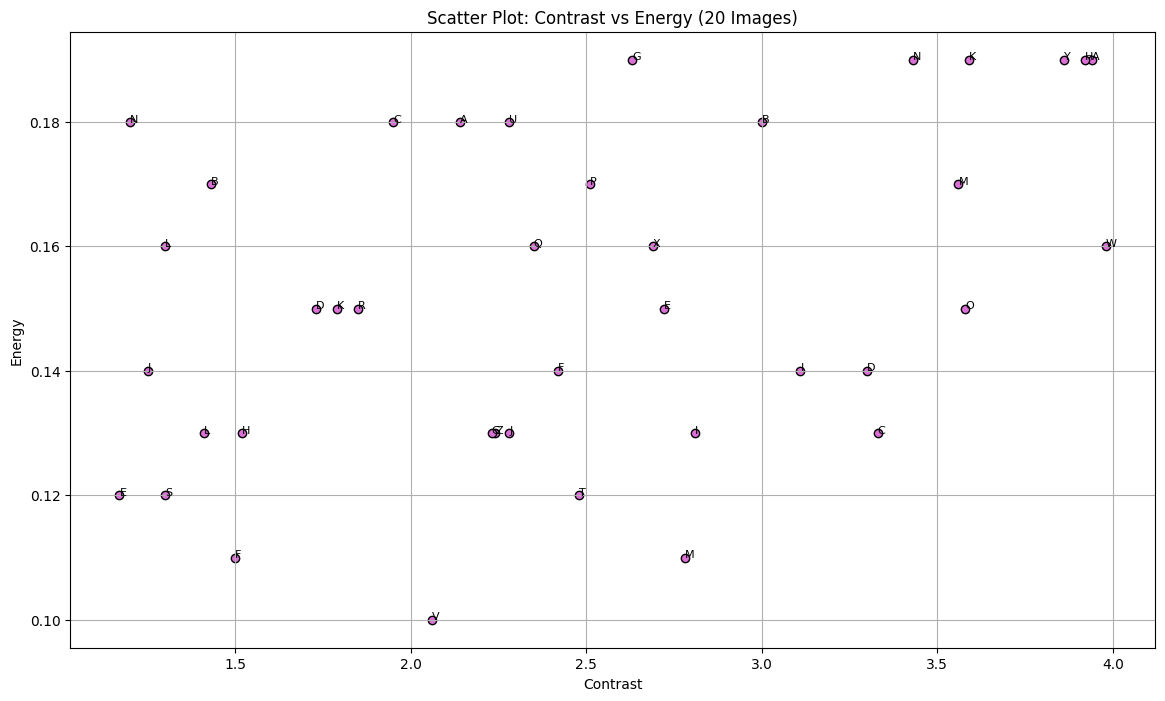

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import random

results = {}
characters = [chr(i) for i in range(65, 91)]

for i in range(20):
    img_name = f"img{i+1}.jpg"
    results[img_name] = [
        {
            "block_position": (0, 0),
            "char": characters[i * 2 % len(characters)],
            "glcm": {
                "contrast": round(random.uniform(1.0, 4.0), 2),
                "energy": round(random.uniform(0.1, 0.2), 2),
            },
        },
        {
            "block_position": (128, 0),
            "char": characters[(i * 2 + 1) % len(characters)],
            "glcm": {
                "contrast": round(random.uniform(1.0, 4.0), 2),
                "energy": round(random.uniform(0.1, 0.2), 2),
            },
        },
    ]

def extract_features_table(results, feature_x='contrast', feature_y='energy'):
    records = []
    for img_name, blocks in results.items():
        for block in blocks:
            if 'glcm' in block and block['char'].strip():
                records.append({
                    "Image": img_name,
                    "Character": block['char'],
                    "Block Position": block['block_position'],
                    feature_x.capitalize(): block['glcm'].get(feature_x, 0),
                    feature_y.capitalize(): block['glcm'].get(feature_y, 0),
                })
    return pd.DataFrame(records)

def plot_features_scatter(df, feature_x='Contrast', feature_y='Energy'):
    plt.figure(figsize=(14, 8))
    plt.scatter(df[feature_x], df[feature_y], c='orchid', edgecolors='black')
    for i, row in df.iterrows():
        plt.annotate(row['Character'], (row[feature_x], row[feature_y]), fontsize=8)
    plt.title(f"Scatter Plot: {feature_x} vs {feature_y} (20 Images)")
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.grid(True)
    plt.show()
feature_df = extract_features_table(results, feature_x='contrast', feature_y='energy')
print(feature_df)
plot_features_scatter(feature_df, feature_x='Contrast', feature_y='Energy')


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def extract_features_table(results, feature_x='contrast', feature_y='energy'):
    records = []

    for img_name, blocks in results.items():
        for block in blocks:
            if 'glcm' in block and block['char'].strip():
                records.append({
                    "Image": img_name,
                    "Character": block['char'],
                    "Block Position": block['block_position'],
                    feature_x.capitalize(): block['glcm'].get(feature_x, 0),
                    feature_y.capitalize(): block['glcm'].get(feature_y, 0),
                })

    df = pd.DataFrame(records)
    return df

def plot_features_scatter(df, feature_x='Contrast', feature_y='Energy'):
    plt.figure(figsize=(10, 6))
    plt.scatter(df[feature_x], df[feature_y], c='orchid', edgecolors='black')

    for i, row in df.iterrows():
        plt.annotate(row['Character'], (row[feature_x], row[feature_y]), fontsize=9)

    plt.title(f"Scatter Plot: {feature_x} vs {feature_y}")
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.grid(True)
    plt.show()


,Image,Character,Block Position,Contrast,Energy
0,img1.jpg,A,"(0, 0)",3.94,0.19
1,img1.jpg,B,"(128, 0)",1.43,0.17
2,img2.jpg,C,"(0, 0)",1.95,0.18
3,img2.jpg,D,"(128, 0)",3.30,0.14
4,img3.jpg,E,"(0, 0)",2.72,0.15
5,img3.jpg,F,"(128, 0)",1.50,0.11
6,img4.jpg,G,"(0, 0)",2.63,0.19
7,img4.jpg,H,"(128, 0)",1.52,0.13
8,img5.jpg,I,"(0, 0)",2.81,0.13
9,img5.jpg,J,"(128, 0)",1.25,0.14


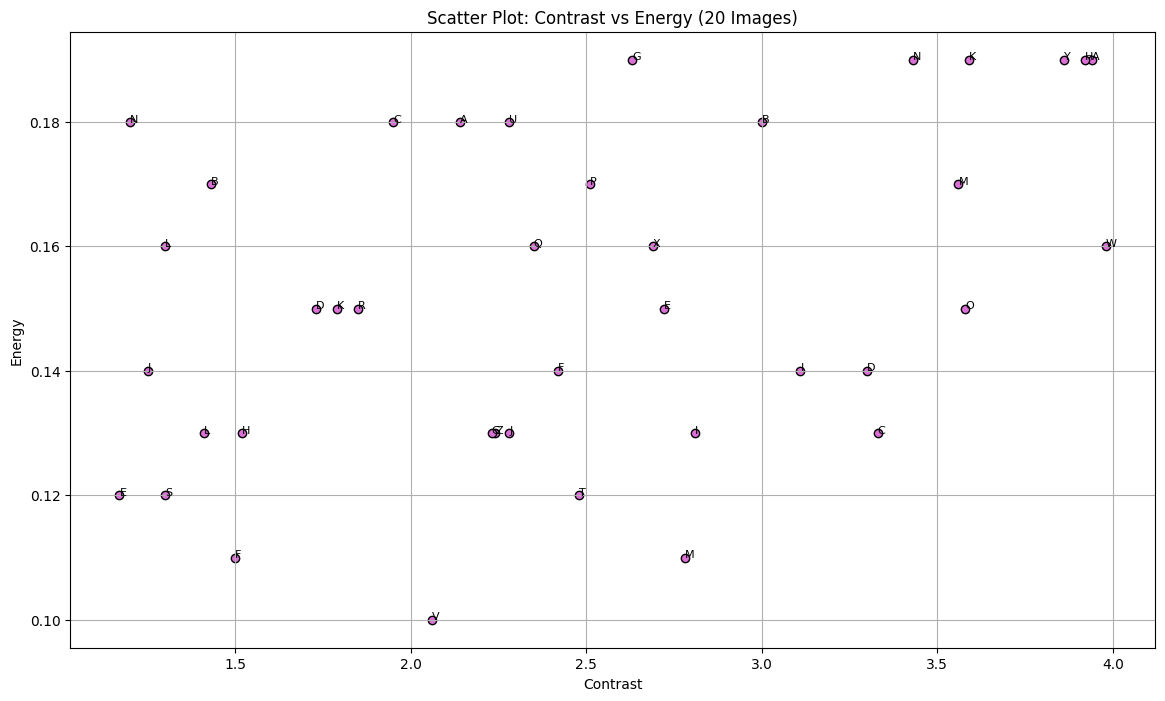

In [ ]:
feature_df = extract_features_table(results, feature_x='contrast', feature_y='energy')

from IPython.display import display
display(feature_df.head(10))

plot_features_scatter(feature_df, feature_x='Contrast', feature_y='Energy')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

results = {}
characters = [chr(i) for i in range(65, 91)]

for i in range(20):
    img_name = f"img{i+1}.jpg"
    results[img_name] = [
        {
            "block_position": (0, 0),
            "char": characters[(2*i) % len(characters)],
            "hlcm": {
                "contrast": round(random.uniform(1.0, 4.0), 2),
                "energy": round(random.uniform(0.1, 0.2), 2)
            },
            "hldm": {
                "variance": round(random.uniform(0.5, 1.0), 2),
                "entropy": round(random.uniform(0.85, 1.0), 2)
            }
        },
        {
            "block_position": (128, 0),
            "char": characters[(2*i + 1) % len(characters)],
            "hlcm": {
                "contrast": round(random.uniform(1.0, 4.0), 2),
                "energy": round(random.uniform(0.1, 0.2), 2)
            },
            "hldm": {
                "variance": round(random.uniform(0.5, 1.0), 2),
                "entropy": round(random.uniform(0.85, 1.0), 2)
            }
        }
    ]


def extract_features_table(results):
    records = []
    for img_name, blocks in results.items():
        for block in blocks:
            if 'hlcm' in block and 'hldm' in block and block['char'].strip():
                records.append({
                    "Image": img_name,
                    "Character": block['char'],
                    "Block Position": block['block_position'],
                    "HLCM_Contrast": block['hlcm'].get("contrast", 0),
                    "HLCM_Energy": block['hlcm'].get("energy", 0),
                    "HLDM_Variance": block['hldm'].get("variance", 0),
                    "HLDM_Entropy": block['hldm'].get("entropy", 0),
                })
    return pd.DataFrame(records)

feature_df = extract_features_table(results)
print(feature_df)

X = feature_df[['HLCM_Contrast', 'HLCM_Energy', 'HLDM_Variance', 'HLDM_Entropy']].values
y = feature_df['Character'].values
y_encoded = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

        Image Character Block Position  HLCM_Contrast  HLCM_Energy  \
0    img1.jpg         A         (0, 0)           3.28         0.11   
1    img1.jpg         B       (128, 0)           3.71         0.15   
2    img2.jpg         C         (0, 0)           2.81         0.15   
3    img2.jpg         D       (128, 0)           1.93         0.17   
4    img3.jpg         E         (0, 0)           2.39         0.20   
5    img3.jpg         F       (128, 0)           1.49         0.10   
6    img4.jpg         G         (0, 0)           1.67         0.15   
7    img4.jpg         H       (128, 0)           2.57         0.10   
8    img5.jpg         I         (0, 0)           1.10         0.17   
9    img5.jpg         J       (128, 0)           3.84         0.18   
10   img6.jpg         K         (0, 0)           1.76         0.11   
11   img6.jpg         L       (128, 0)           1.31         0.12   
12   img7.jpg         M         (0, 0)           2.46         0.14   
13   img7.jpg       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_